# Data Cleaning


1. Including all the necessary modules required.

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

2. Reading and Inspecting data

In [95]:
df = pd.read_csv("dirty_cafe_sales.csv")
df_clean = df.copy()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [96]:
for cols in df_clean.columns:
  if cols != 'Transaction Date':
    print(cols, df_clean[cols].unique())

Transaction ID ['TXN_1961373' 'TXN_4977031' 'TXN_4271903' ... 'TXN_5255387' 'TXN_7695629'
 'TXN_6170729']
Item ['Coffee' 'Cake' 'Cookie' 'Salad' 'Smoothie' 'UNKNOWN' 'Sandwich' nan
 'ERROR' 'Juice' 'Tea']
Quantity ['2' '4' '5' '3' '1' 'ERROR' 'UNKNOWN' nan]
Price Per Unit ['2.0' '3.0' '1.0' '5.0' '4.0' '1.5' nan 'ERROR' 'UNKNOWN']
Total Spent ['4.0' '12.0' 'ERROR' '10.0' '20.0' '9.0' '16.0' '15.0' '25.0' '8.0' '5.0'
 '3.0' '6.0' nan 'UNKNOWN' '2.0' '1.0' '7.5' '4.5' '1.5']
Payment Method ['Credit Card' 'Cash' 'UNKNOWN' 'Digital Wallet' 'ERROR' nan]
Location ['Takeaway' 'In-store' 'UNKNOWN' nan 'ERROR']


3. It can be seen that all values are stored in object datatype and there are some missing values too. So we make the following changes -

*   Convert total spent, quantity and price per unit columns to numeric data type
*   Populate missing values
*   Convert transaction date to datetime data type
*   Add column transaction month







In [97]:
# Converting total spent, quantity and price per unit columns to numeric data type
df_clean[['Total Spent', 'Quantity', 'Price Per Unit']] = df_clean[['Total Spent', 'Quantity', 'Price Per Unit']].apply(pd.to_numeric, errors='coerce', axis=1)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9667 non-null   object 
 2   Quantity          9521 non-null   float64
 3   Price Per Unit    9467 non-null   float64
 4   Total Spent       9498 non-null   float64
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  9841 non-null   object 
dtypes: float64(3), object(5)
memory usage: 625.1+ KB


In [98]:
# Making a dict of prices for each Item
prices = {'Cookie' : 1.0 , 'Tea' : 1.5, 'Coffee' : 2.0, 'Salad' : 5.0, 'Juice' : 3.0, 'Cake' : 3.0, 'Sandwich' : 4.0, 'Smoothie' : 4.0}
# Populating price per unit column where values are missing
df_clean['Price Per Unit'] = df_clean.apply(lambda row: prices.get(row['Item']) if pd.isna(row['Price Per Unit']) else row['Price Per Unit'], axis=1)

In [99]:
# Dropping rows where Price Per Unit is NaN
df_clean.dropna(subset=['Price Per Unit'], inplace=True)
# Dropping rows where Total Spent & Quantity is NaN
df_clean.dropna(subset=['Total Spent', 'Quantity'], how='all', inplace=True)

df_clean.isna().sum()

,0
Transaction ID,0
Item,310
Quantity,456
Price Per Unit,0
Total Spent,479
Payment Method,2555
Location,3237
Transaction Date,157


In [100]:
# Populating Price Per Unit column with (Total Spent / Quantity)
df_clean['Price Per Unit'] = df_clean.apply(lambda row: row['Total Spent'] / row['Quantity'] if pd.isna(row['Price Per Unit']) else row['Price Per Unit'], axis=1)
# Populating Total Spent (Quantity * Price Per Unit)
df_clean['Total Spent'] = df_clean.apply(lambda row: row['Quantity'] * row['Price Per Unit'] if pd.isna(row['Total Spent']) else row['Total Spent'], axis=1)
# Populating Quantity (Total Spent / Price Per Unit)
df_clean['Quantity'] = df_clean.apply(lambda row: row['Total Spent'] * row['Price Per Unit'] if pd.isna(row['Quantity']) else row['Quantity'], axis=1)

df_clean.isna().sum()

,0
Transaction ID,0
Item,310
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,2555
Location,3237
Transaction Date,157


In [101]:
# Converting UNKNOWN & ERROR Items to NaN
df_clean['Item'] = df_clean['Item'].replace({'UNKNOWN': np.nan, 'ERROR': np.nan})
df_clean[df_clean['Item'].isna()]
# Populating Item (Based on prices)
df_clean['Item'] = df_clean.apply(lambda row: next((k for k, v in prices.items() if v == row['Price Per Unit']), row['Item']), axis=1)

In [102]:
# Converting to date
df_clean['Transaction Date'] = pd.to_datetime(df_clean['Transaction Date'], errors='coerce')
# Dropping rows where Transaction Date is NaN
df_clean.dropna(subset=['Transaction Date'], inplace=True)
# Add new column 'Transaction Month'
df_clean['Transaction Month'] = pd.to_datetime(df_clean['Transaction Date']).dt.strftime('%B')

df_clean.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Transaction Month
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,September
1,TXN_4977031,Juice,4.0,3.0,12.0,Cash,In-store,2023-05-16,May
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19,July
3,TXN_7034554,Salad,2.0,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27,April
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11,June


In [103]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9469 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Transaction ID     9469 non-null   object        
 1   Item               9469 non-null   object        
 2   Quantity           9469 non-null   float64       
 3   Price Per Unit     9469 non-null   float64       
 4   Total Spent        9469 non-null   float64       
 5   Payment Method     7054 non-null   object        
 6   Location           6377 non-null   object        
 7   Transaction Date   9469 non-null   datetime64[ns]
 8   Transaction Month  9469 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 739.8+ KB


In [104]:
df_clean.isna().sum()

,0
Transaction ID,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,2415
Location,3092
Transaction Date,0
Transaction Month,0


In [105]:
# Checking nulls and the count of other unique values
print(f'Null:{df_clean["Location"].isna().sum()}')
df_clean['Location'].value_counts()

Null:3092


,count
Location,
Takeaway,2869
In-store,2850
ERROR,339
UNKNOWN,319


In [106]:
values = ['Takeaway', 'In-store']  # List of valid values for Location
df_clean['Location'] = df_clean['Location'].apply(lambda x: x if x in values else np.nan)  # Transforming values outside the valid values list into nulls

# Generating an index only with the null values in the 'Location' column
nan_indices = df_clean['Location'][df_clean['Location'].isna()].index

# Iterating through NaN indices and filling with alternating values
for i in nan_indices:
  df_clean.loc[i, 'Location'] = values[0]  # Filling with the current value of valids
  values.reverse()  # Reversing the values of valid to distribute the values equally

# Checking nulls and the count of other unique values
print(f'Nulls:{df_clean["Location"].isna().sum()}')
df_clean['Location'].value_counts()

Nulls:0


,count
Location,
Takeaway,4744
In-store,4725


In [107]:
vv = ['Cash', 'Credit Card',"Digital Wallet"]  # List of valid values
df_clean['Payment Method'] = df_clean['Payment Method'].apply(lambda x: x if x in vv else np.nan)  # Transforming values outside the vv list into nulls

# Generating an index only with the null values in the 'Payment Method' column
nan_indices = df_clean['Payment Method'][df_clean['Payment Method'].isna()].index

# Iterating through NaN indices and filling with alternating values
for i in nan_indices:
  df_clean.loc[i, 'Payment Method'] = vv[0]  # Filling with the current value of vv
  vv = vv[1:] + [vv[0]]  # Rotating the values of vv to distribute the values equally

# Checking nulls and the count of other unique values
print(f'Nulls:{df_clean["Payment Method"].isna().sum()}')
df_clean['Payment Method'].value_counts()

Nulls:0


,count
Payment Method,
Digital Wallet,3178
Credit Card,3147
Cash,3144


In [108]:
df_clean.isna().sum()

,0
Transaction ID,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,0
Location,0
Transaction Date,0
Transaction Month,0


In [109]:
df_clean

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Transaction Month
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,September
1,TXN_4977031,Juice,4.0,3.0,12.0,Cash,In-store,2023-05-16,May
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19,July
3,TXN_7034554,Salad,2.0,5.0,10.0,Cash,Takeaway,2023-04-27,April
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11,June
...,...,...,...,...,...,...,...,...,...
9994,TXN_7851634,Sandwich,4.0,4.0,16.0,Cash,Takeaway,2023-01-08,January
9995,TXN_7672686,Coffee,2.0,2.0,4.0,Credit Card,In-store,2023-08-30,August
9997,TXN_5255387,Coffee,4.0,2.0,8.0,Digital Wallet,Takeaway,2023-03-02,March
9998,TXN_7695629,Cookie,3.0,1.0,3.0,Digital Wallet,In-store,2023-12-02,December


In [110]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9469 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Transaction ID     9469 non-null   object        
 1   Item               9469 non-null   object        
 2   Quantity           9469 non-null   float64       
 3   Price Per Unit     9469 non-null   float64       
 4   Total Spent        9469 non-null   float64       
 5   Payment Method     9469 non-null   object        
 6   Location           9469 non-null   object        
 7   Transaction Date   9469 non-null   datetime64[ns]
 8   Transaction Month  9469 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 997.8+ KB


Now the data cleaning is complete.

The dataframe started with ten thousand (10,000) rows and ended with nine thousand four hundred and sixty-nine (9,469), meaning that 5.31% of the data was lost.

In [111]:
#Saving cleaned data
df_clean.to_csv('cleaned_cafe_sales.csv', index=False)

# Exploratory Data Analysis (EDA)

In [112]:
#Summary statistics for numerical columns
for i in df_clean.columns:
  if np.dtype(df_clean[i]) == int or np.dtype(df_clean[i]) == float:
    print(df_clean[i].describe())

count    9469.000000
mean        4.270435
std         8.724546
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max       125.000000
Name: Quantity, dtype: float64
count    9469.000000
mean        2.949097
std         1.279818
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Price Per Unit, dtype: float64
count    9469.000000
mean        8.918418
std         6.008964
min         1.000000
25%         4.000000
50%         8.000000
75%        12.000000
max        25.000000
Name: Total Spent, dtype: float64


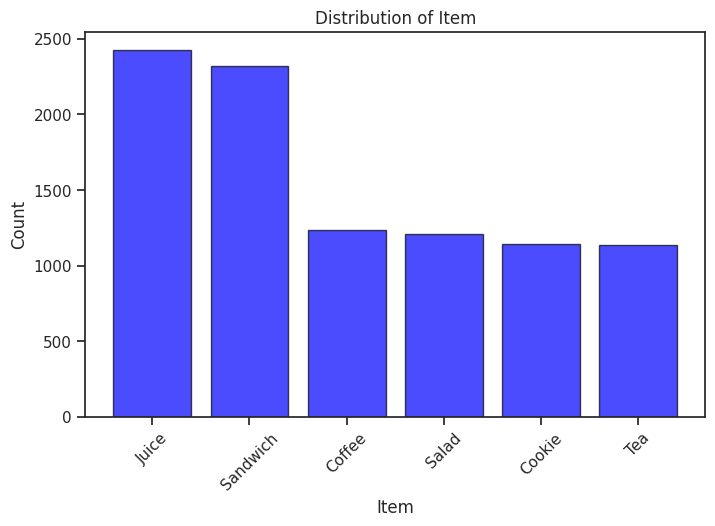

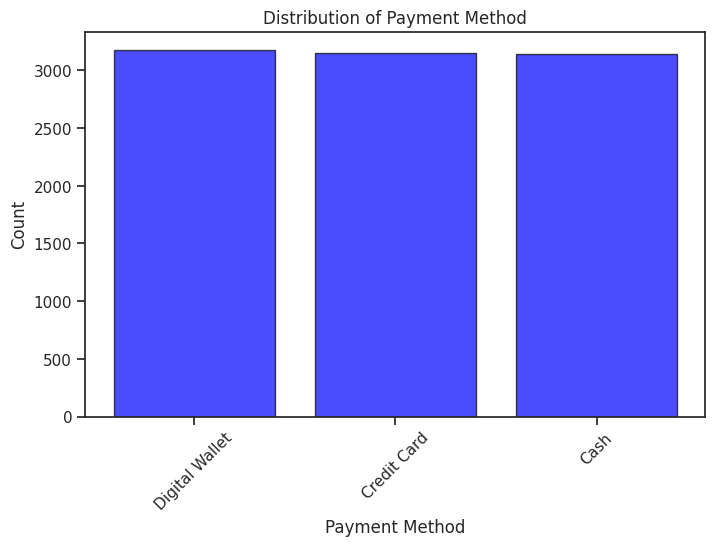

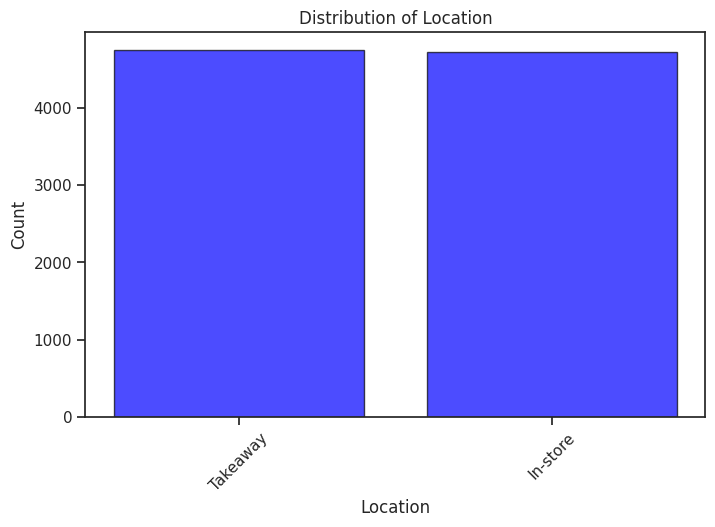

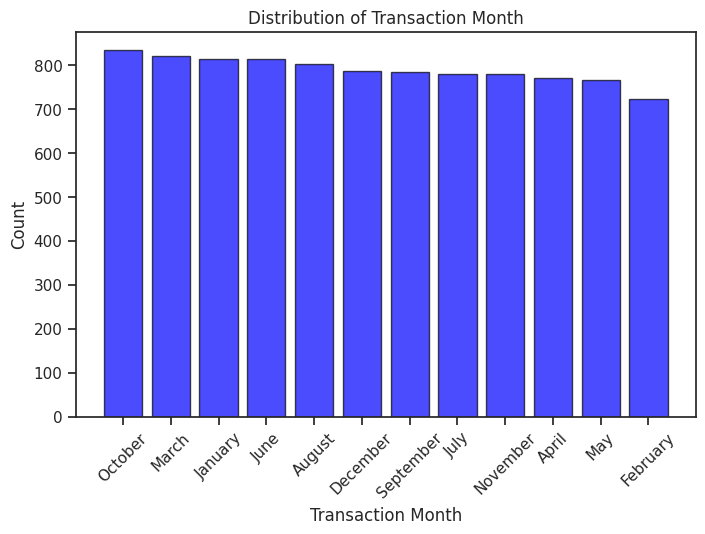

In [113]:
# Frequency distributions for categorical columns
for i in df_clean.columns:
    if np.dtype(df_clean[i]) == object and i != 'Transaction ID':

        plt.figure(figsize=(8, 5))
        value_counts = df_clean[i].value_counts()

        plt.bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, edgecolor='black')

        plt.title(f'Distribution of {i}')
        plt.xlabel(i)
        plt.ylabel('Count')

        plt.xticks(rotation=45)
        plt.show()

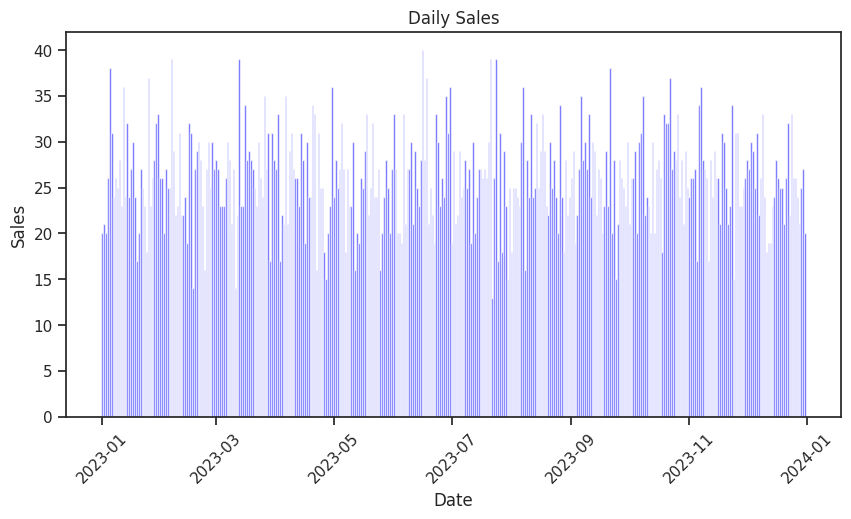

In [114]:
# Daily Sales Analysis
sales_by_day = df_clean.groupby('Transaction Date').size().reset_index(name='Sales Count')

plt.figure(figsize=(10, 5))
plt.bar(sales_by_day['Transaction Date'], sales_by_day['Sales Count'], color='blue', alpha=0.7)

plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.xticks(rotation=45)
plt.show()

In this graph, the variation in sales per day during the year was analyzed. The graph did not show any total difference in the number of sales during the year, only peaks of high and low in a certain seasonality.

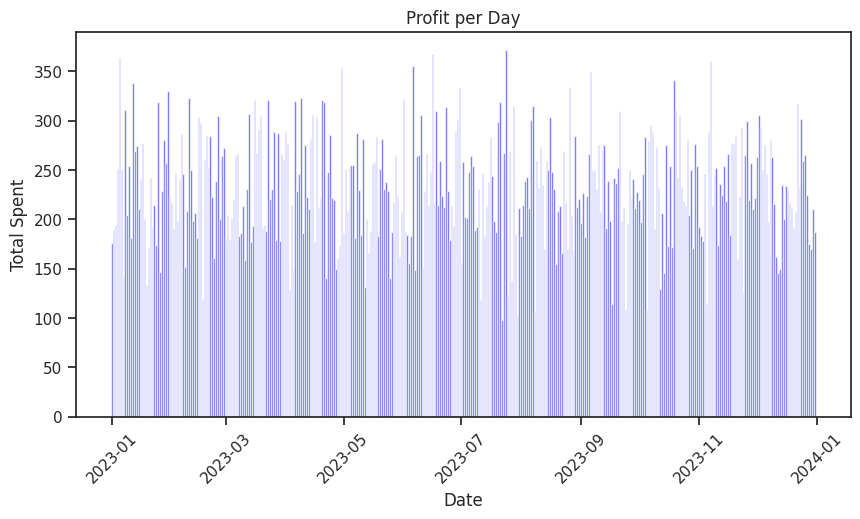

In [115]:
dfx = df_clean.groupby('Transaction Date')['Total Spent'].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(dfx['Transaction Date'], dfx['Total Spent'], color='blue', alpha=0.7)

plt.title('Profit per Day')
plt.xlabel('Date')
plt.ylabel('Total Spent')

plt.xticks(rotation=45)
plt.show()

This chart was created to determine if there is a change in profit throughout the year, such as a more expensive product being sold more in the summer or winter. However, the profit does not seem to have this type of variation. The outliers appear more visible than in the sales chart, although they are still quite similar in terms of stable variation.

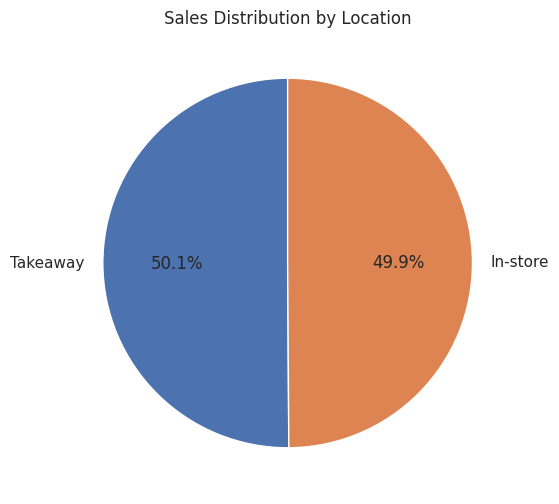

In [116]:
df_clean_counts = df_clean['Location'].value_counts().reset_index()
df_clean_counts.columns = ['Location', 'Count']

plt.figure(figsize=(6, 6))
plt.pie(df_clean_counts['Count'], labels=df_clean_counts['Location'], autopct='%1.1f%%', startangle=90)

plt.title('Sales Distribution by Location')
plt.show()

The division is equal in terms of location.


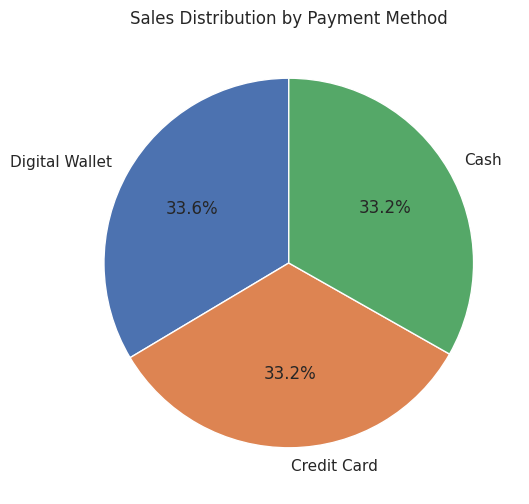

In [117]:
df_clean_counts = df_clean['Payment Method'].value_counts().reset_index()
df_clean_counts.columns = ['Payment Method', 'Count']

plt.figure(figsize=(6, 6))
plt.pie(df_clean_counts['Count'], labels=df_clean_counts['Payment Method'], autopct='%1.1f%%', startangle=90)

plt.title('Sales Distribution by Payment Method')
plt.show()

The division is equal in terms of payment methods.

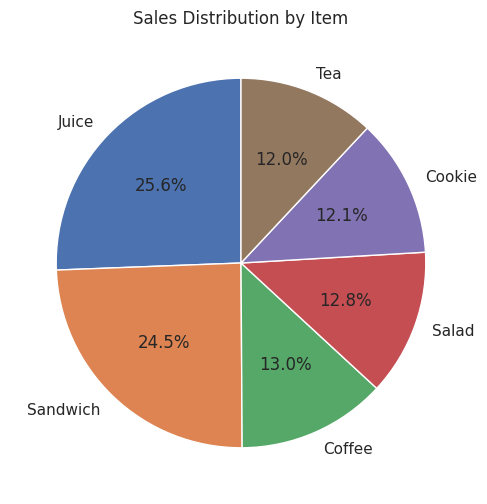

In [118]:
df_clean_counts = df_clean['Item'].value_counts().reset_index()
df_clean_counts.columns = ['Item', 'Count']

plt.figure(figsize=(6, 6))
plt.pie(df_clean_counts['Count'], labels=df_clean_counts['Item'], autopct='%1.1f%%', startangle=90)

plt.title('Sales Distribution by Item')
plt.show()

Sandwich and Juice got the highest number of sales and the division is almost equal in the remaining items.

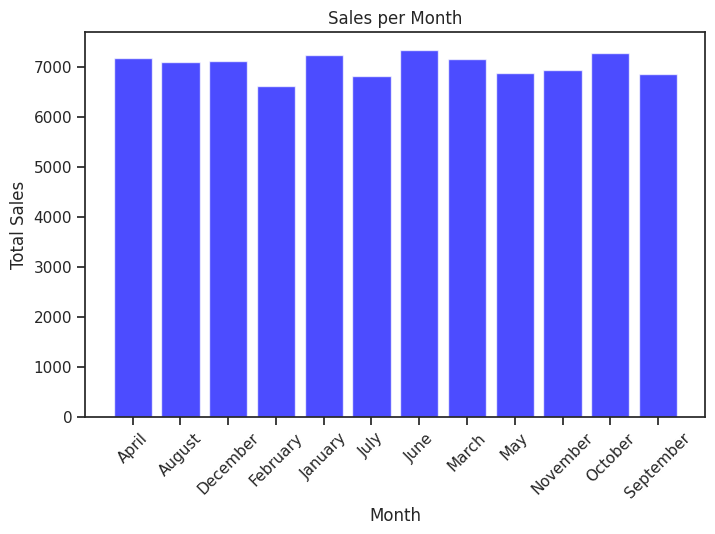

In [119]:
dfx = df_clean.groupby('Transaction Month')['Total Spent'].sum().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(dfx['Transaction Month'], dfx['Total Spent'], color='blue', alpha=0.7)

plt.title('Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')

plt.xticks(rotation=45)
plt.show()

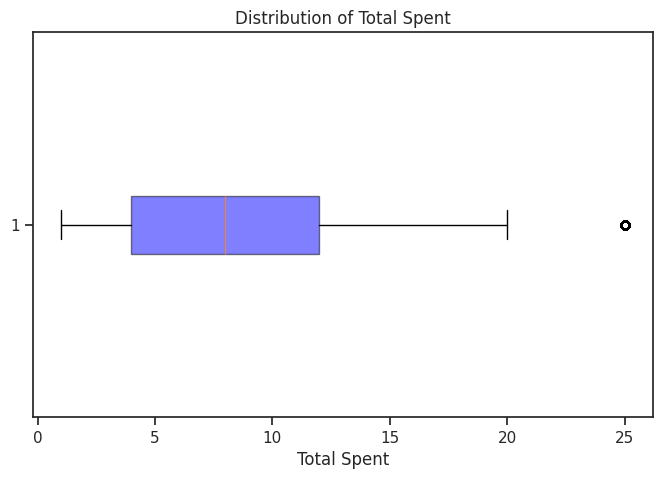

In [120]:
# Box plots
plt.figure(figsize=(8, 5))
plt.boxplot(df_clean['Total Spent'], vert=False, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.5))

plt.title('Distribution of Total Spent')
plt.xlabel('Total Spent')

plt.show()

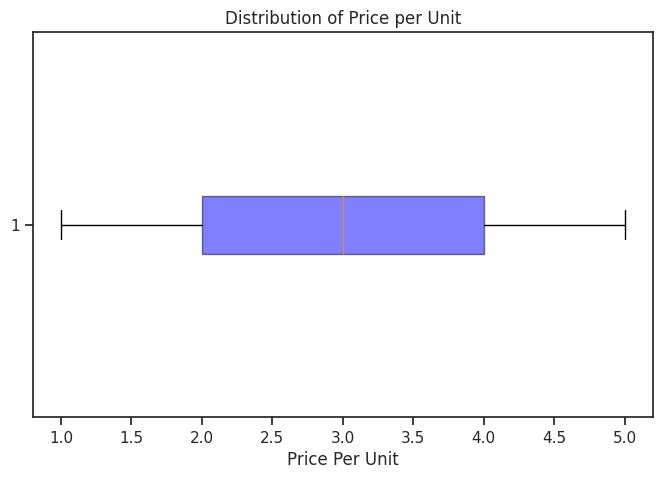

In [121]:
plt.figure(figsize=(8, 5))
plt.boxplot(df_clean['Price Per Unit'], vert=False, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.5))

plt.title('Distribution of Price per Unit')
plt.xlabel('Price Per Unit')

plt.show()

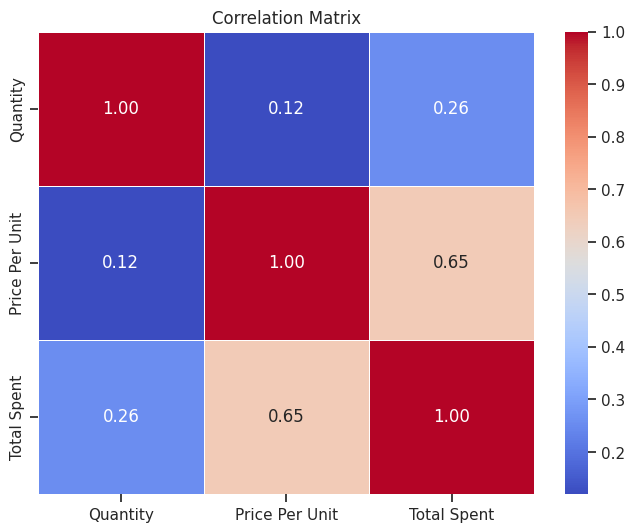

In [122]:
# Correlation matrix
df_clean_numerical = df_clean.select_dtypes(include=[np.number])
df_clean_categorical = df_clean.select_dtypes(include=[object])
df_clean_categorical = df_clean_categorical.drop(columns=['Transaction ID'], errors='ignore')

corr_matrix = df_clean_numerical.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix')
plt.show()

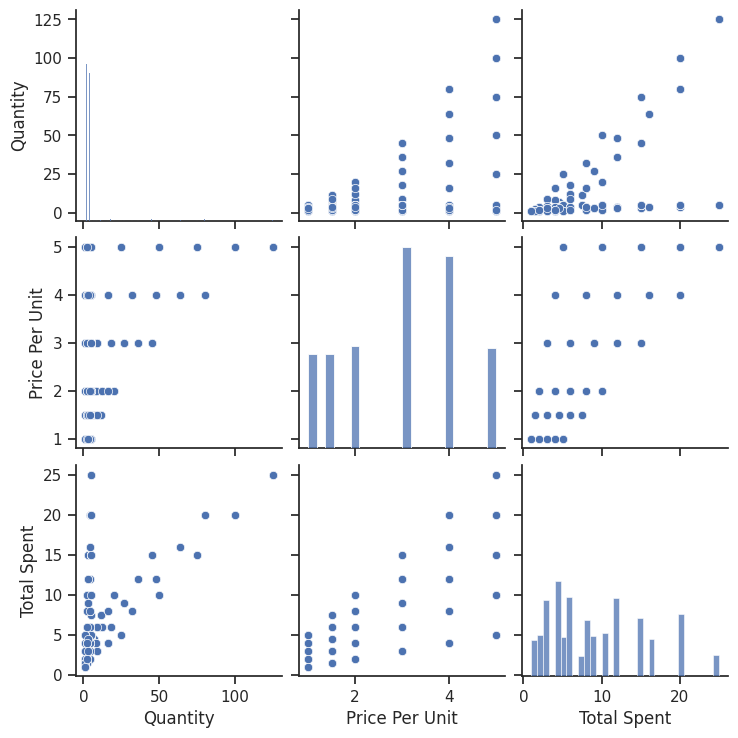

In [123]:
# Pairplot
sns.pairplot(df_clean_numerical)
plt.show()

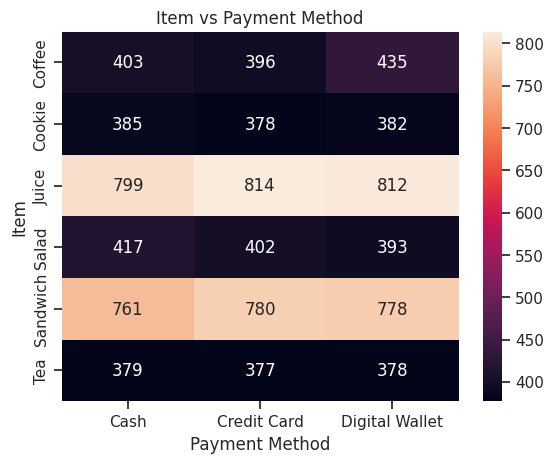

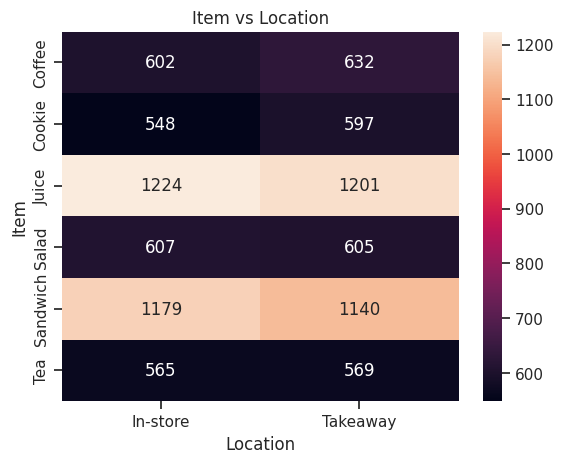

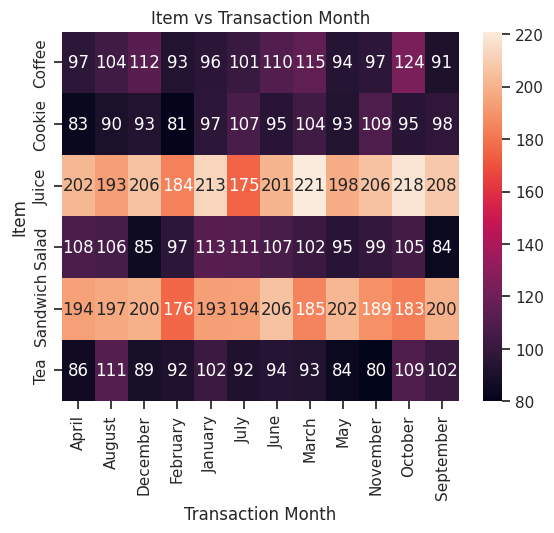

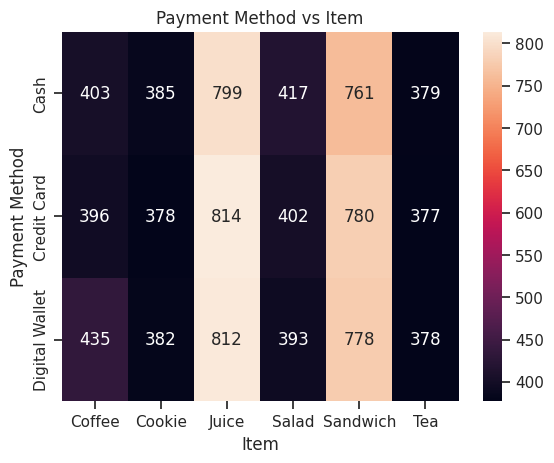

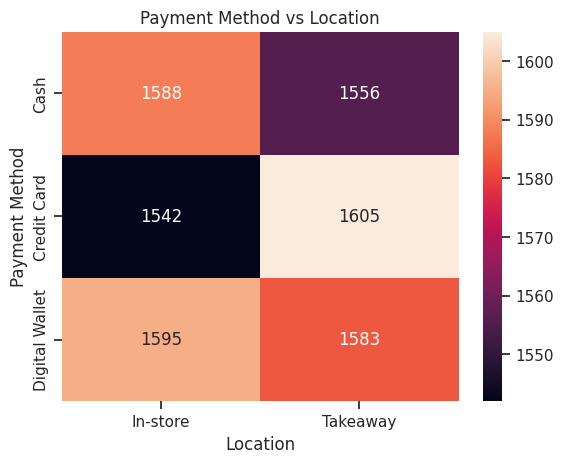

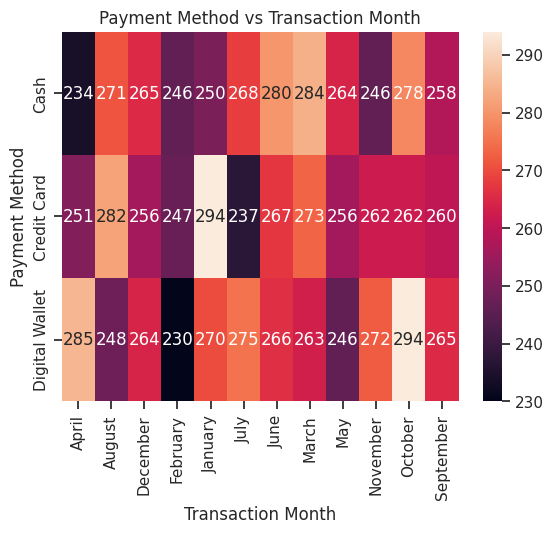

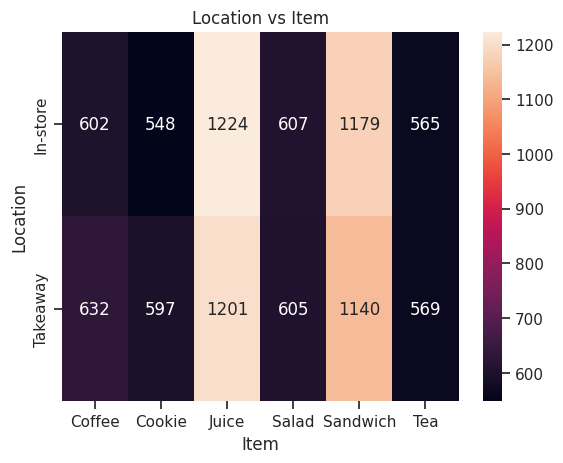

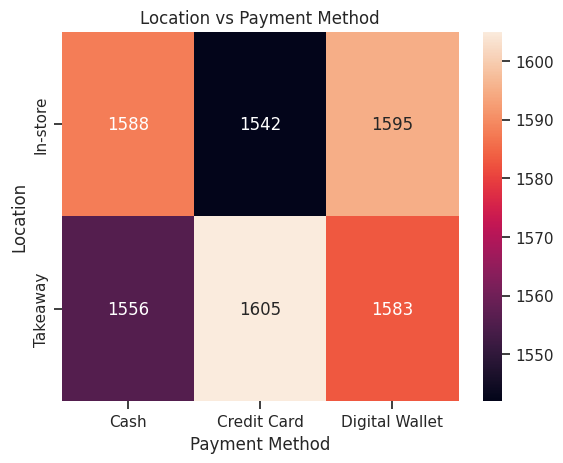

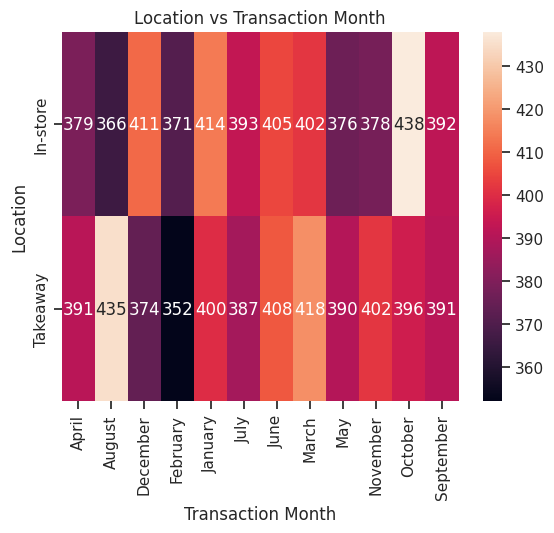

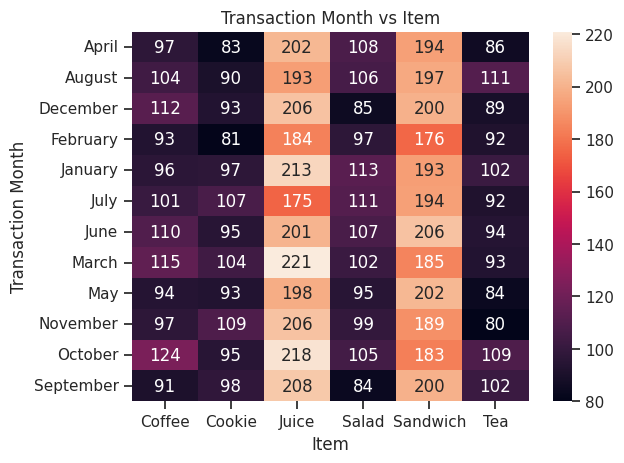

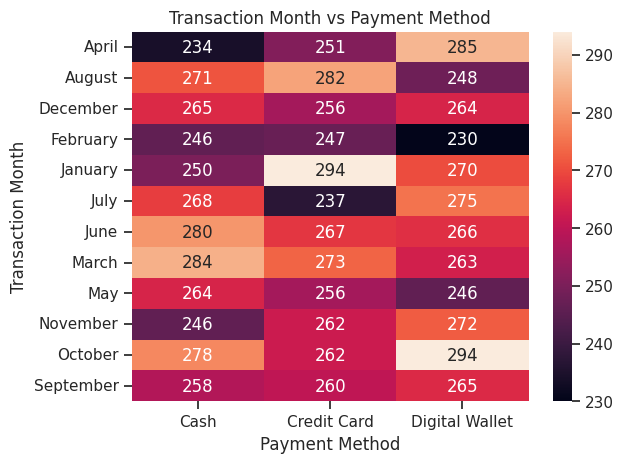

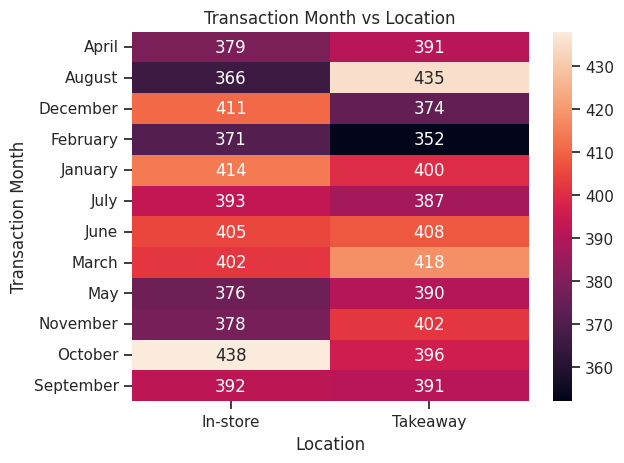

In [124]:
# Heatmaps for all categorical variables
for i in df_clean_categorical:
  for j in df_clean_categorical:
    if i != j:
      fig = sns.heatmap(pd.crosstab(df_clean[i], df_clean[j]), annot=True, fmt='d')
      fig.set_title(f'{i} vs {j}')
      plt.show()

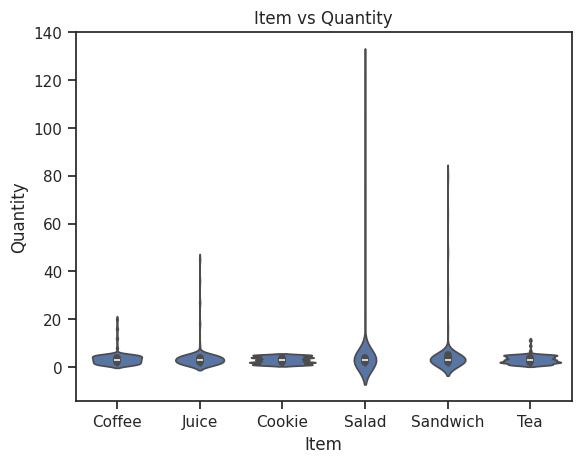

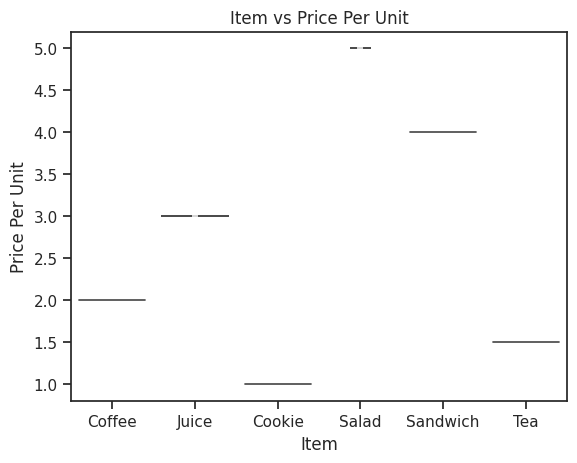

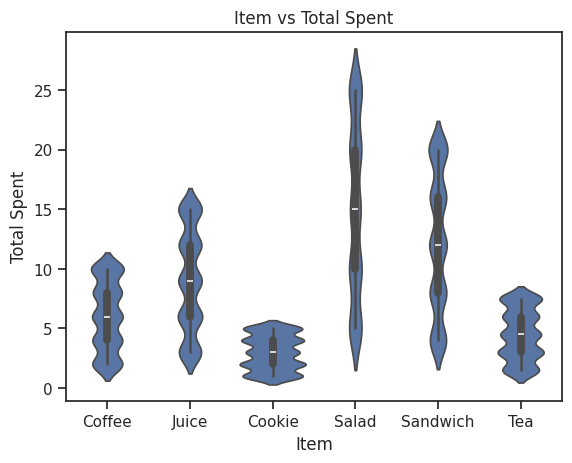

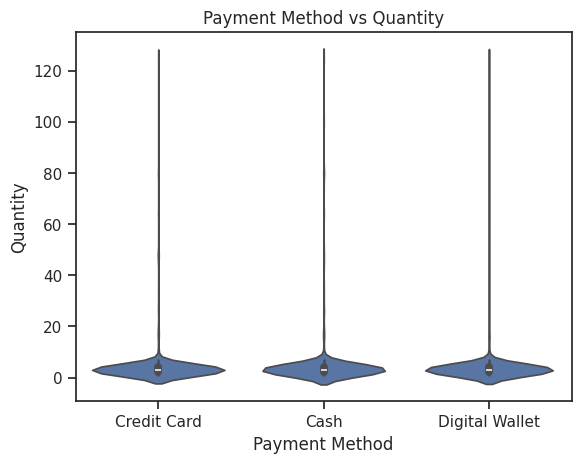

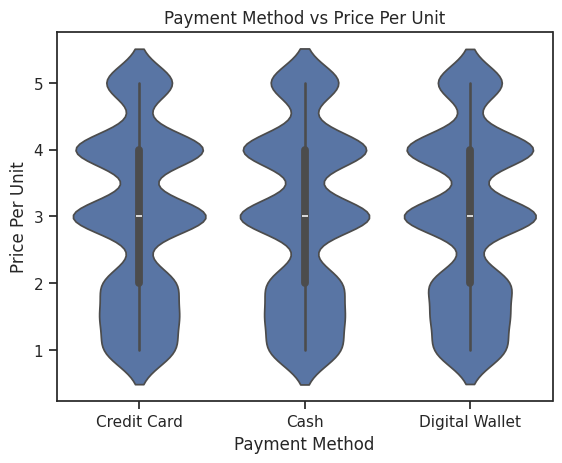

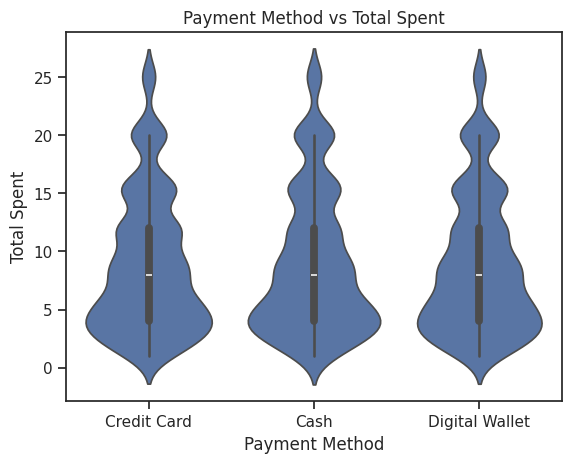

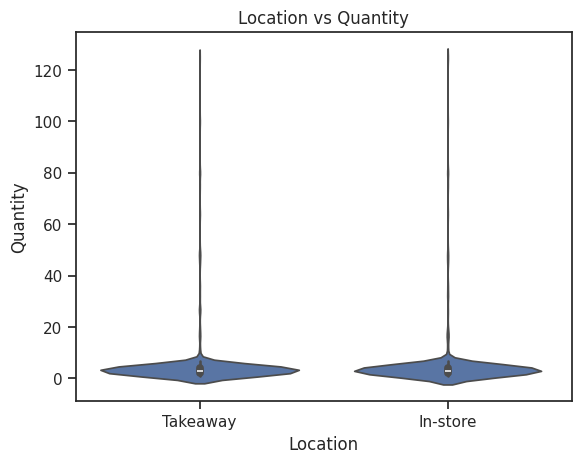

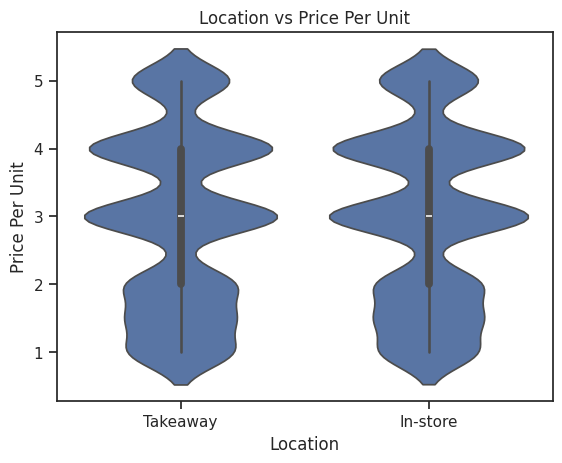

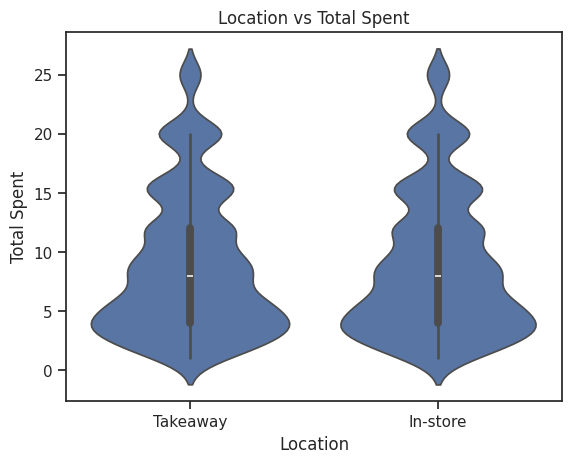

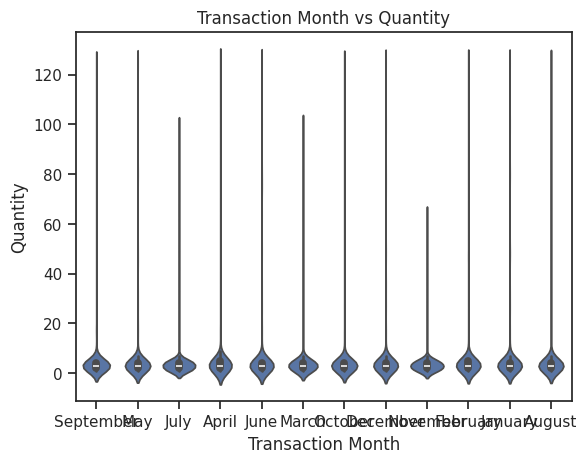

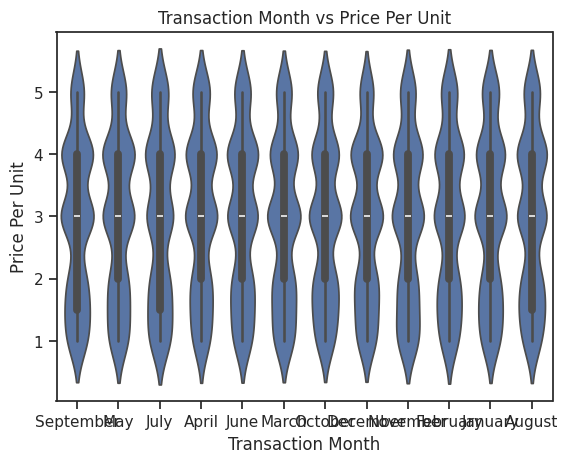

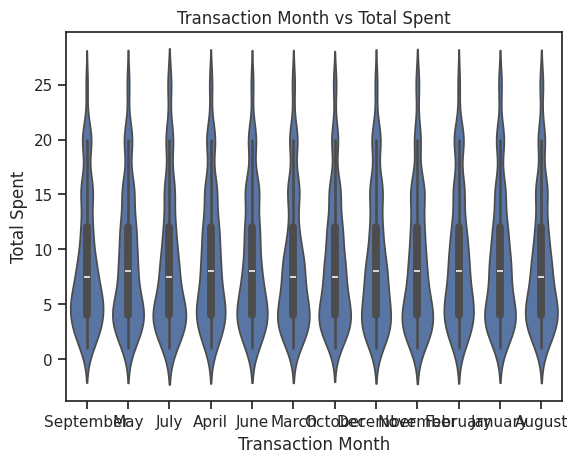

In [125]:
# Violin plots to compare categorical and numerical variables.
for i in df_clean_categorical:
  for j in df_clean_numerical:
    fig = sns.violinplot(x=df_clean[i], y=df_clean[j])
    fig.set_title(f'{i} vs {j}')
    plt.show()

In [126]:
# Quantity Sold Per Month
df_quantities_pivot = df_clean.pivot_table(index='Transaction Month', columns='Item', values='Quantity', aggfunc='sum')
df_quantities_pivot.reset_index(inplace=True)
df_quantities_pivot['Transaction Month No'] = pd.to_datetime(df_quantities_pivot['Transaction Month'], format='%B').dt.month
df_quantities_pivot.sort_values('Transaction Month No', inplace=True)
df_quantities_pivot.drop(columns='Transaction Month No', inplace=True)

# Monthly Revenue
df_revenue_pivot = df_clean.pivot_table(index='Transaction Month', columns='Item', values='Total Spent', aggfunc='sum')
df_revenue_pivot.reset_index(inplace=True)
df_revenue_pivot['Transaction Month No'] = pd.to_datetime(df_quantities_pivot['Transaction Month'], format='%B').dt.month
df_revenue_pivot.sort_values('Transaction Month No', inplace=True)
df_revenue_pivot.drop(columns='Transaction Month No', inplace=True)
df_revenue_pivot['Monthly Revenue'] = df_revenue_pivot[list(['Sandwich','Juice','Cookie','Coffee','Tea','Salad'])].sum(axis=1)

# Revenue by Item
revenue = df_clean.groupby('Item')['Total Spent'].agg(['sum']).sort_values(by='sum', ascending=False)

# Distribution of Total Spent across Payment Method
df_pm = pd.melt(df_clean, id_vars='Payment Method', value_vars=['Total Spent'], var_name='features', value_name='values')

df_revenue_pivot

Item,Transaction Month,Coffee,Cookie,Juice,Salad,Sandwich,Tea,Monthly Revenue
4,January,592.0,292.0,1929.0,1665.0,2304.0,456.0,7238.0
3,February,612.0,246.0,1662.0,1330.0,2332.0,426.0,6608.0
7,March,726.0,301.0,1866.0,1560.0,2280.0,423.0,7156.0
0,April,586.0,247.0,1944.0,1610.0,2384.0,393.0,7164.0
8,May,568.0,278.0,1836.0,1370.0,2444.0,376.5,6872.5
6,June,646.0,284.0,1827.0,1640.0,2520.0,417.0,7334.0
5,July,638.0,317.0,1491.0,1715.0,2236.0,409.5,6806.5
1,August,638.0,281.0,1770.0,1580.0,2348.0,475.5,7092.5
11,September,522.0,310.0,1788.0,1245.0,2536.0,450.0,6851.0
10,October,750.0,281.0,2019.0,1545.0,2152.0,522.0,7269.0


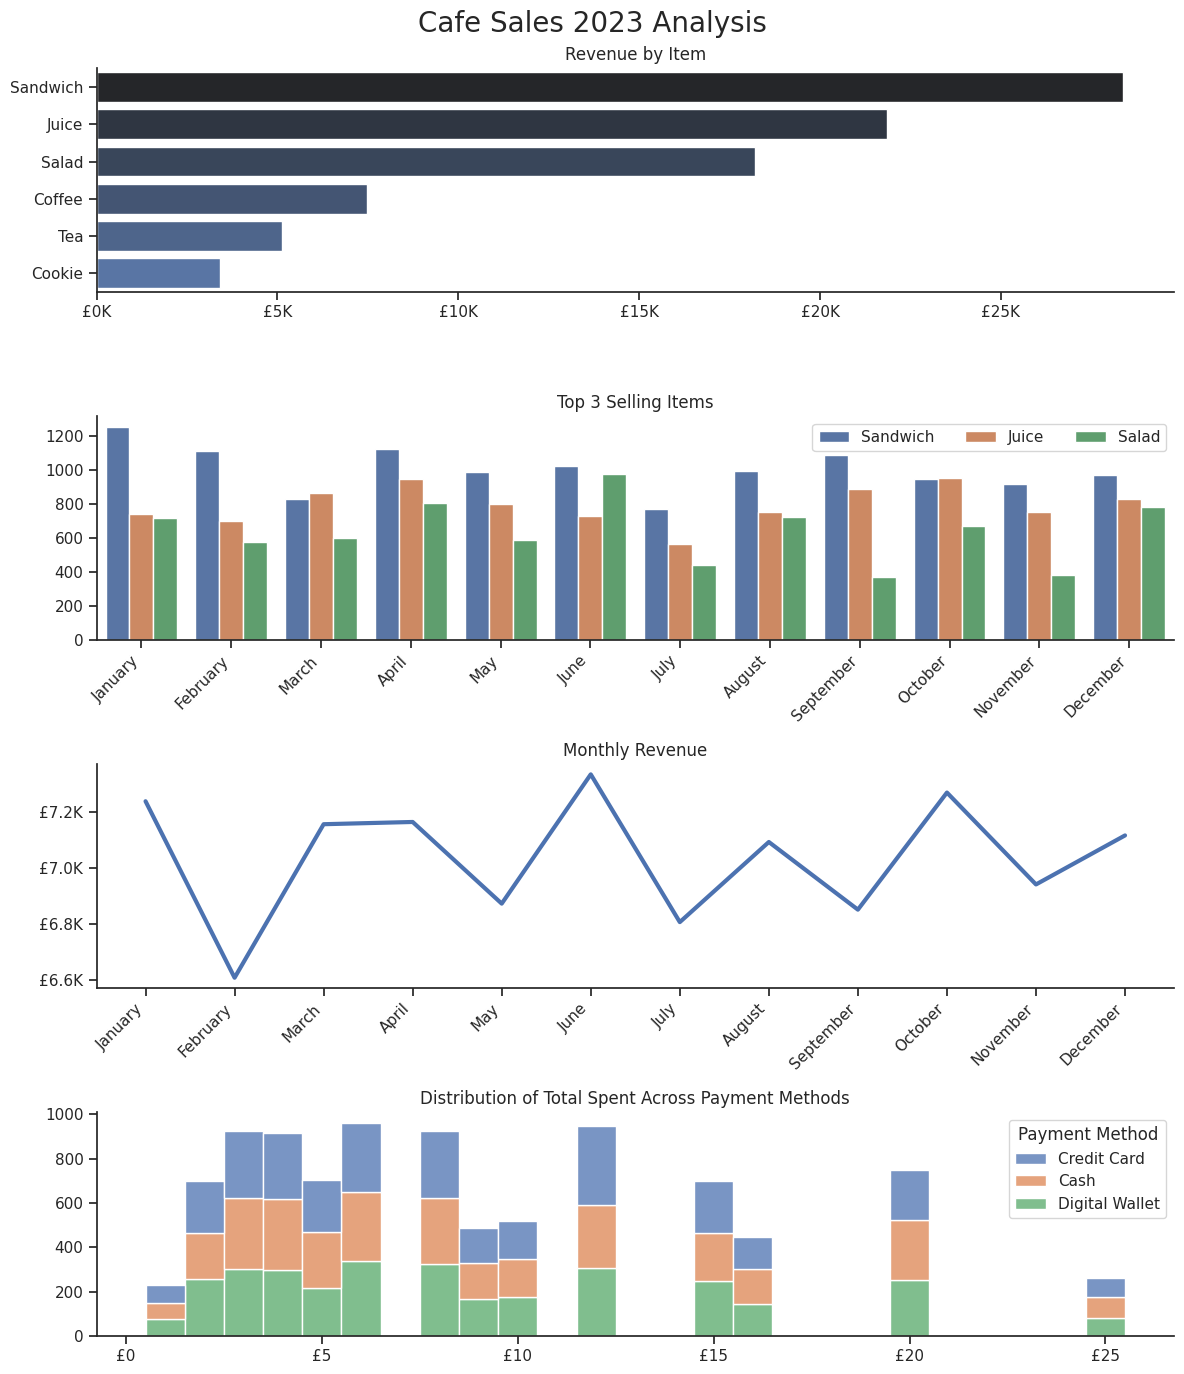

In [127]:
fig, ax = plt.subplots(4,1, figsize=(12,14))

# Revenue by Item
sns.set_theme(style='ticks')
sns.barplot(data=revenue, x='sum', y=revenue.index, palette='dark:b', ax=ax[0])
sns.despine()
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('Revenue by Item')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{int(x/1000)}K'))

# Top 3 Selling Items
top_3 = df_clean.groupby('Item')['Quantity'].agg(['sum']).sort_values(by='sum', ascending=False)
top_3 = top_3.head(3).index.tolist()
df_top_3 = df_quantities_pivot.melt(id_vars='Transaction Month', value_vars=top_3, var_name='Item', value_name='Quantity')
sns.barplot(data=df_top_3, x='Transaction Month', y='Quantity', hue='Item', ax=ax[1])
ax[1].set_title('Top 3 Selling Items')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
plt.setp(ax[1].get_xticklabels(), rotation=45, ha='right')
ax[1].legend(loc='upper right', ncol=3)

# Monthly Revenue
sns.lineplot(data=df_revenue_pivot, x='Transaction Month', y='Monthly Revenue', linewidth=3, ax=ax[2])
ax[2].set_title('Monthly Revenue')
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x/1000:.1f}K'))
plt.setp(ax[2].get_xticklabels(), rotation=45, ha='right')

# Distribution of Total Spent across Payment Method
sns.histplot(data=df_pm, x='values', hue='Payment Method', multiple='stack', discrete=True, ax=ax[3])
ax[3].set_title('Distribution of Total Spent Across Payment Methods')
ax[3].set_xlabel('')
ax[3].set_ylabel('')
ax[3].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{int(x)}'))


fig.suptitle('Cafe Sales 2023 Analysis', fontsize=20)
fig.tight_layout()

# Final Inference

**Revenue by Item**

 We can observe that Sandwich generated the highest revenue, earning approximately £5k more than the second-highest item, while cookie generated the lowest revenue.

**Top 3 Selling Items**

 Month by month, Sandwich is usually the most purchased item, with sales peaking in June as summer begins. Sales dip in September, likely due to the arrival of Autumn, but overall, this pattern indicates that people are health conscious. Juices and salads are also among the top selling items, further supporting the trend of health conscious consumer choices. This aligns with the fact that the highest revenue-generating items are sandwiches, juices and salads.

**Monthly Revenue**

 The monthly revenue consistently falls between £6.5k and £7.5k, with February being the lowest revenue month. After the festive season in December and the New Year, people tend to tighten their budgets, hence this could result in fewer visits to cafes in February. A promotion could be a good strategy to boost revenue during February, such as Valentine's-themed specials. October and June are the highest revenue months, suggesting that as the weather cools, people are more inclined to enjoy warm drinks.

**Distribution of Total Spent across Payment Method**

 Credit card, cash, and digital wallet appear to be used equally as payment methods, regardless of the total amount spent. There is no evident pattern indicating that any particular payment method is more commonly used for larger payments. For instance, when the total spent is £20, digital wallet is the most common payment method. However, when the total spent reaches £25, both digital wallet and cash are used less frequently than credit card. Total spent may correlate with payment method for specific customer segments, such as demographics but not at a general level.